In [14]:
from pathlib import Path
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_data = pd.read_csv(Path('../Resources/CleanedDataset.csv'))
df_data = df_data.drop(columns='Unnamed: 0')
df_status = pd.read_csv(Path('../Resources/Status.csv'))
df = df_status.join(df_data, how='left')
df

,STATUS,AMT_INCOME_TOTAL,AGE,YEARS_EXPERIENCE,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0,112500.0,58,3,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,270000.0,46,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17038,1,315000.0,47,6,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
17039,0,157500.0,33,3,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17040,0,157500.0,33,3,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17041,1,283500.0,49,1,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### No Scaler PCA and KMeans clustering

In [4]:
pca = PCA(n_components=2)
loan_pca = pca.fit_transform(df)
var_ratio = pca.explained_variance_ratio_
print(loan_pca[:5], var_ratio)

[[-8.28769807e+04  1.59292302e+01]
 [ 7.46230193e+04  1.11381479e+01]
 [ 7.46230193e+04  1.11380279e+01]
 [ 7.46230193e+04  1.11380279e+01]
 [ 7.46230192e+04  3.43533355e+00]] [9.99999988e-01 8.92090824e-09]


In [5]:
loan_pca_df = pd.DataFrame(
    loan_pca,
    columns=['PCA1', 'PCA2']
)

inertia = []
k = list(range(1,11))

for j in k:
    k_model = KMeans(n_clusters=j, random_state=129)
    k_model.fit(loan_pca_df)
    inertia.append(k_model.inertia_)

pca_elbow_data = {'k': k, 'inertia' : inertia}
pd.DataFrame(pca_elbow_data).hvplot.line(
    x='k',
    y='inertia',
    title='Elbow Curve',
    xticks=k
)

:Curve   [k]   (inertia)

In [6]:
# Calculating variance ratio of first two PCA variables
print(f"The Variance ratio of the first two PCA variables is: {round((var_ratio[0] + var_ratio[1]) * 100)}%")

The Variance ratio of the first two PCA variables is: 100%


The variance ratio for the first two PCA variables is 0.999999988 and 8.92090824e-09 which is around 100% of the total variance. This is either perfect or terrible.

The best number of clusters is 4 according to the elbow curve.

In [7]:
model = KMeans(n_clusters=4, random_state=129)
model.fit(loan_pca_df)
k_4 = model.predict(loan_pca_df)

loan_pca_predictions_df = loan_pca_df.copy()
loan_pca_predictions_df['loan_segments'] = k_4

In [8]:
loan_pca_predictions_df.hvplot.scatter(
    x='PCA1',
    y='PCA2',
    by='loan_segments'
)

:NdOverlay   [loan_segments]
   :Scatter   [PCA1]   (PCA2)

This graph shows a fairly clean spread of the data. There are no extreme outliers.

Zooming in shows some clear verticle lines.

In [9]:
df['PCA_k4_cluster'] = k_4

In [10]:
df.to_csv('clustered.csv', index=False)
df.head()

,STATUS,AMT_INCOME_TOTAL,AGE,YEARS_EXPERIENCE,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,PCA_k4_cluster
0,0,112500.0,58,3,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,0,270000.0,52,8,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,1,270000.0,46,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df.hvplot.scatter(
    x='AMT_INCOME_TOTAL',
    y='AGE',
    by='PCA_k4_cluster'
)

:NdOverlay   [PCA_k4_cluster]
   :Scatter   [AMT_INCOME_TOTAL]   (AGE)

In [40]:
df_plot = df[['STATUS', 'PCA_k4_cluster']]
df_plot = df_plot.groupby(['PCA_k4_cluster', 'STATUS']).size().unstack()
df_plot


STATUS,0,1
PCA_k4_cluster,,
0,5832,2452
1,4719,1945
2,1352,551
3,125,67


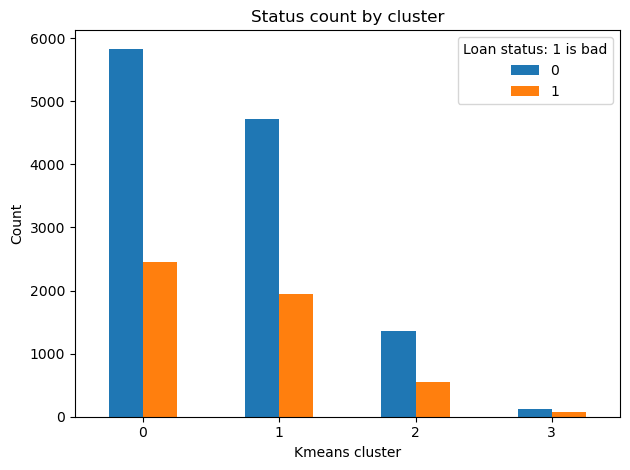

In [41]:
def plot_grouped_bar_chart(df_plot, x_label, y_label, title):
    df_plot.plot(kind='bar', stacked=False)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title='Loan status: 1 is bad')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_grouped_bar_chart(df_plot=df_plot, x_label='Kmeans cluster', y_label='Count', title='Status count by cluster')

In [42]:
df_plot = df[['FLAG_OWN_REALTY_Y', 'PCA_k4_cluster']]
df_plot = df_plot.groupby(['PCA_k4_cluster', 'FLAG_OWN_REALTY_Y']).size().unstack()
df_plot

FLAG_OWN_REALTY_Y,0,1
PCA_k4_cluster,,
0,3053,5231
1,2389,4275
2,573,1330
3,45,147


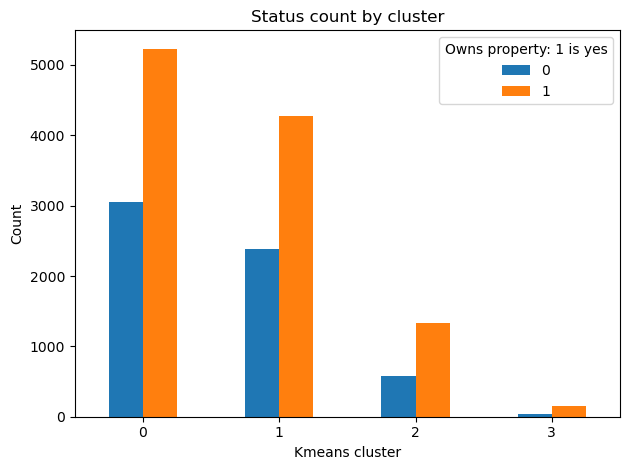

In [43]:
def plot_grouped_bar_chart(df_plot, x_label, y_label, title):
    df_plot.plot(kind='bar', stacked=False)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title='Owns property: 1 is yes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_grouped_bar_chart(df_plot=df_plot, x_label='Kmeans cluster', y_label='Count', title='Status count by cluster')